In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = "retina"

# ResNet

## Import

In [2]:
import sys
sys.path.insert(0, "../src")

In [3]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import scipy
from sklearn import metrics
from sklearn import model_selection

import torch
import torch.nn as nn
import torch.nn.functional as F
torch.backends.cudnn.benchmark = True

import albumentations as A

import dataset
import engine
import optimizers
import utils

In [4]:
SEED = 42
utils.seed_everything(SEED)

## Data

In [5]:
DATA_PATH = Path("../input")
df = pd.read_csv(DATA_PATH / "train.csv"); df.head()

,id,digit,letter,0,1,2,3,4,5,6,...,774,775,776,777,778,779,780,781,782,783
0,1,5,L,1,1,1,4,3,0,0,...,2,1,0,1,2,4,4,4,3,4
1,2,0,B,0,4,0,0,4,1,1,...,0,3,0,1,4,1,4,2,1,2
2,3,4,L,1,1,2,2,1,1,1,...,3,3,3,0,2,0,3,0,2,2
3,4,9,D,1,2,0,2,0,4,0,...,3,3,2,0,1,4,0,0,1,1
4,5,6,A,3,0,2,4,0,3,0,...,4,4,3,2,1,3,4,3,1,2


## Model

### ResNet

In [6]:
sigmoid = torch.nn.Sigmoid()

class Swish(torch.autograd.Function):
    @staticmethod
    def forward(ctx, i):
        result = i * sigmoid(i)
        ctx.save_for_backward(i)
        return result

    @staticmethod
    def backward(ctx, grad_output):
        i = ctx.saved_tensors[0]
        sigmoid_i = sigmoid(i)
        return grad_output * (sigmoid_i * (1 + i * (1 - sigmoid_i)))

swish = Swish.apply

class Swish_module(nn.Module):
    def forward(self, x):
        return swish(x)

swish_layer = Swish_module()
def relu_fn(x):
    """ Swish activation function """
    # return x * torch.sigmoid(x)
    return swish_layer(x)

In [13]:
def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)

class PreActBlock(nn.Module):
    """Pre-activation version of the BasicBlock"""
    expansion = 1
    
    def __init__(self, in_planes, planes, stride=1):
        super(PreActBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = conv3x3(in_planes, planes, stride)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes)
        
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False)
            )
        else:
            self.shortcut = nn.Sequential()
            
    def forward(self, x):
        x = F.relu(self.bn1(x))
        shortcut = self.shortcut(x)
        x = self.conv1(x)
        out = self.conv2(F.relu(self.bn2(x)))
        out += shortcut
        return out
    
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(in_planes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
    
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [14]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64
        
        self.conv1 = conv3x3(1, 64)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(1024*block.expansion, num_classes)
        
    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        avg_feats = F.adaptive_avg_pool2d(x, output_size=1)
        avg_feats = avg_feats.view(avg_feats.size(0), -1)
        max_feats = F.adaptive_max_pool2d(x, output_size=1)
        max_feats = max_feats.view(max_feats.size(0), -1)
        x = torch.cat([avg_feats, max_feats], dim=1)

        x = self.linear(x)
        
        return x
    
def ResNet18():
    return ResNet(PreActBlock, [2,2,2,2])

def ResNet34():
    return ResNet(BasicBlock, [3,4,6,3])

def ResNet50():
    return ResNet(Bottleneck, [3,4,6,3])

### xResNet

In [30]:
def conv(ni, nf, kernel_size=3, stride=1, bias=False):
    return nn.Conv2d(ni, nf, kernel_size=kernel_size, stride=stride, padding=kernel_size//2, bias=bias)

def conv_layer(ni, nf, kernel_size=3, stride=1, zero_batch_norm=False, use_act=True):
    """Creates a convolutional block for `XResNet`."""
    bn = nn.BatchNorm2d(nf)
    nn.init.constant_(bn.weight, 0. if zero_batch_norm else 1.)
    layers = [conv(ni, nf, kernel_size=kernel_size, stride=stride), bn,]
    if use_act: layers.append(nn.ReLU(inplace=True))
    return nn.Sequential(*layers)

In [ ]:
def xResNetBlock(nn.Module):
    """Creates the standard `XResNet` block."""
    def __init__(self, expansion, ni, nh, stride=1):
        super(xResNetBlock, self).__init__()
        ni = ni * expansion
        nf = nh * expansion
        
        if expansion == 1:
            layers = []
        else:
            layers = []
        self.convs = nn.Sequential(*layers)
        
        shortcut = []
        if ni == nf:
            shortcut.append(nn.Identity())
        else:
            shortcut.append(conv_layer(ni, nf, kernel_size=1, use_act=False))
        if stride == 1:
            shortcut.append(nn.Identity())
        else:
            shortcut.append(nn.AvgPool2d(2, ceil_mode=True))
        self.shortcut = nn.Sequential(*shortcut)
            
    def forward(self, x):
        x = self.convs(x) + self.shortcut(x)
        x = F.relu(x)
        return x

In [35]:
model = nn.Sequential()
inp = torch.randn(3, 1, 28, 28)
o1 = model(inp)
o2 = nn.Identity()(inp)
o1.eq(o2).float().mean()

tensor(1.)

## Train

In [15]:
def run(epochs, optim_name, lr, wd, augs=None, label_smooth=True, mixup=False, cutmix=False):
    device = torch.device("cuda")
    oof = np.zeros((len(df), 10))
    targs = np.zeros(len(df))
    
    for fold in range(5):
        train_indices = np.load(DATA_PATH / f"train_idx-fold{fold}.npy")
        valid_indices = np.load(DATA_PATH / f"valid_idx-fold{fold}.npy")
        train_dataset = dataset.EMNISTDataset(df, train_indices, augs=augs)
        valid_dataset = dataset.EMNISTDataset(df, valid_indices)
        train_loader = torch.utils.data.DataLoader(
            train_dataset, batch_size=64, shuffle=True, num_workers=2, pin_memory=True
        )
        valid_loader = torch.utils.data.DataLoader(
            valid_dataset, batch_size=256, num_workers=2, pin_memory=True
        )

        model = ResNet50().cuda()
        
        skip_list = ["bias", "bn"]
        params = []
        exclude_params = []
        for name, param in model.named_parameters():
            if not param.requires_grad: continue
            elif any(skip in name for skip in skip_list):
                exclude_params.append(param)
            else:
                params.append(param)
        optim_params = [
            {"params": params, "weight_decay": wd},
            {"params": exclude_params, "weight_decay": 0.0},
        ]
        
        if optim_name == "radam":
            optimizer = optimizers.RAdam(optim_params, lr=lr)
        elif optim_name == "adam":
            optimizer = torch.optim.Adam(optim_params, lr=lr)
        else:
            raise RuntimeError("Unknown optimizer:", optim_name)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
        scaler = torch.cuda.amp.GradScaler()
    
        train_accuracies = []
        valid_accuracies = []
    
        for epoch in range(epochs):
            # Train
            train_loss, train_accuracy = engine.train(
                train_loader,
                model,
                optimizer,
                device,
                scaler,
                label_smooth=label_smooth,
                mixup=mixup,
                cutmix=cutmix,
            )
            scheduler.step()
            train_accuracies.append(train_accuracy)

            # Validate
            valid_probs, valid_targs, valid_loss, valid_accuracy = engine.evaluate(valid_loader, model, device)          
            valid_accuracies.append(valid_accuracy)
            if epoch % 10 == 0:
                print(f"Epoch={epoch}, Train loss={train_loss:.5f}, Valid loss={valid_loss:.5f}, Train Accuracy={train_accuracy:.5f}, Validation Accuracy={valid_accuracy:.5f}")

        valid_probs, valid_targs, valid_loss, valid_accuracy = engine.evaluate(valid_loader, model, device)
        print(f"Fold={fold}, Valid loss={valid_loss:.5f}, Valid Accuracy={valid_accuracy:.5f}")
        
        # oof prediction
        oof[valid_indices] = scipy.special.softmax(valid_probs, axis=1)
        targs[valid_indices] = valid_targs

        # Plot training curve
        rng = np.arange(len(train_accuracies))
        plt.plot(rng, train_accuracies, label="Train")
        plt.plot(rng, valid_accuracies, label="Validation")
        plt.title(f"Training curve for fold{fold}")
        plt.ylabel("Accuracy")
        plt.xlabel("Epoch")
        plt.legend()
        plt.show()

    # Confusion matrix
    conf = metrics.confusion_matrix(targs, np.argmax(oof, axis=1))
    plt.figure(figsize=(9, 7))
    sns.heatmap(conf, cmap="coolwarm", annot=True, fmt="d")
    plt.ylabel("True")
    plt.xlabel("Predicted")
    plt.show()

    # Classification report
    print(metrics.classification_report(targs, np.argmax(oof, axis=1)))

    return oof, targs

In [16]:
augs = A.Compose([
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0, rotate_limit=10, p=0.5),
    A.Normalize(mean=0.143, std=0.254, max_pixel_value=255.0, always_apply=True,),
])

In [ ]:
%%time
epochs = 200
model_name = "resnet50"
optim_name = "adam"
lr = 3e-3
wd = 5e-4
oof, targs = run(epochs, optim_name, lr, wd, augs, label_smooth=True, mixup=False, cutmix=True)
preds = np.argmax(oof, axis=1)
accuracy = metrics.accuracy_score(targs, preds)
print(f"CV Accuracy Score={accuracy}")
print(f"model={model_name}, optimizer={optim_name}, epochs={epochs}, lr={lr}, wd={wd}")

Epoch=0, Train loss=9.34271, Valid loss=43661.92990, Train Accuracy=0.11580, Validation Accuracy=0.09046
Epoch=10, Train loss=2.64487, Valid loss=3.04590, Train Accuracy=0.11240, Validation Accuracy=0.12714
Epoch=20, Train loss=2.69045, Valid loss=3.80091, Train Accuracy=0.13108, Validation Accuracy=0.14181
Epoch=30, Train loss=2.42955, Valid loss=2.14052, Train Accuracy=0.16690, Validation Accuracy=0.21027
Epoch=40, Train loss=2.49568, Valid loss=3.00753, Train Accuracy=0.15443, Validation Accuracy=0.20293
Epoch=50, Train loss=2.44207, Valid loss=2.80265, Train Accuracy=0.11516, Validation Accuracy=0.11002


Epoch=0, Train loss=4.45837, Valid loss=2.39049, Train Accuracy=0.09809, Validation Accuracy=0.09291
Epoch=10, Train loss=2.25714, Valid loss=2.16127, Train Accuracy=0.23483, Validation Accuracy=0.26895
Epoch=20, Train loss=2.09244, Valid loss=1.94858, Train Accuracy=0.36491, Validation Accuracy=0.47433
Epoch=30, Train loss=1.78523, Valid loss=1.86719, Train Accuracy=0.53965, Validation Accuracy=0.62592
Epoch=40, Train loss=1.76956, Valid loss=1.20058, Train Accuracy=0.55761, Validation Accuracy=0.65770
Epoch=50, Train loss=1.67977, Valid loss=1.41134, Train Accuracy=0.59650, Validation Accuracy=0.60880
Epoch=60, Train loss=1.77525, Valid loss=1.11421, Train Accuracy=0.55794, Validation Accuracy=0.72127
Epoch=70, Train loss=1.69234, Valid loss=1.76898, Train Accuracy=0.60306, Validation Accuracy=0.54034
Epoch=80, Train loss=1.56717, Valid loss=0.79967, Train Accuracy=0.65125, Validation Accuracy=0.82396
Epoch=90, Train loss=1.66582, Valid loss=1.28602, Train Accuracy=0.61194, Validatio

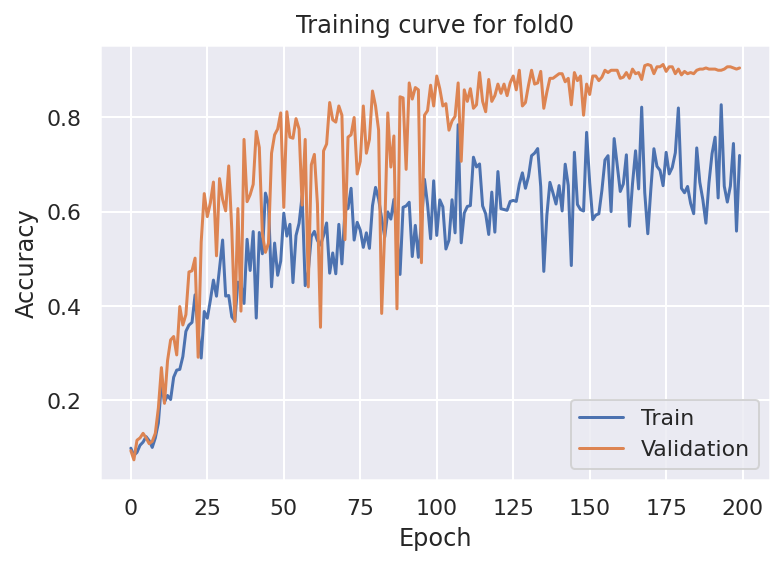

Epoch=0, Train loss=3.86907, Valid loss=282868.66204, Train Accuracy=0.10817, Validation Accuracy=0.05610
Epoch=10, Train loss=2.22868, Valid loss=1.81203, Train Accuracy=0.27316, Validation Accuracy=0.38537
Epoch=20, Train loss=2.18781, Valid loss=1.72674, Train Accuracy=0.26730, Validation Accuracy=0.44146
Epoch=30, Train loss=2.04887, Valid loss=1.34020, Train Accuracy=0.38444, Validation Accuracy=0.58293
Epoch=40, Train loss=1.90108, Valid loss=1.43398, Train Accuracy=0.47189, Validation Accuracy=0.62683
Epoch=50, Train loss=1.92175, Valid loss=1.89321, Train Accuracy=0.48791, Validation Accuracy=0.33415
Epoch=60, Train loss=1.94600, Valid loss=1.80001, Train Accuracy=0.48224, Validation Accuracy=0.35610
Epoch=70, Train loss=1.69109, Valid loss=0.97839, Train Accuracy=0.59589, Validation Accuracy=0.79268
Epoch=80, Train loss=1.96155, Valid loss=1.30379, Train Accuracy=0.46914, Validation Accuracy=0.73902
Epoch=90, Train loss=1.71093, Valid loss=0.89781, Train Accuracy=0.59311, Vali

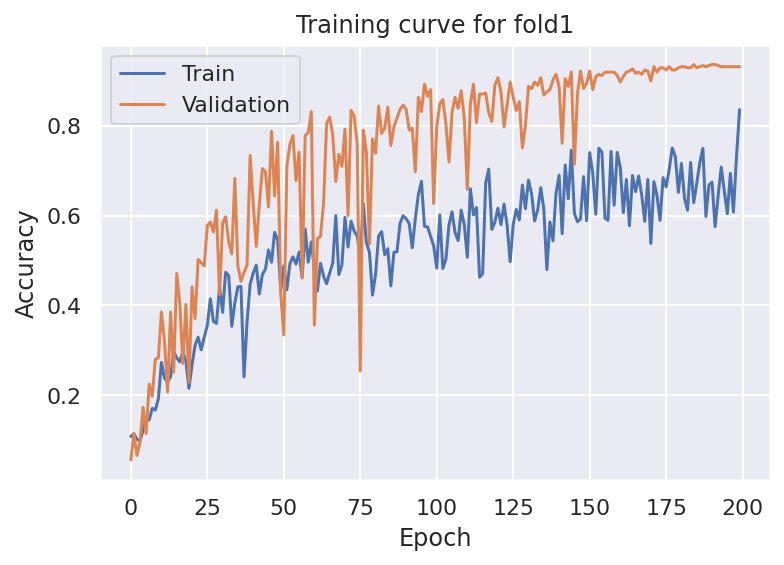

Epoch=0, Train loss=4.63836, Valid loss=85.32030, Train Accuracy=0.10307, Validation Accuracy=0.12439
Epoch=10, Train loss=2.37056, Valid loss=2.63282, Train Accuracy=0.17016, Validation Accuracy=0.23415
Epoch=20, Train loss=2.22939, Valid loss=1.82506, Train Accuracy=0.27635, Validation Accuracy=0.39512
Epoch=30, Train loss=1.95306, Valid loss=1.56983, Train Accuracy=0.42633, Validation Accuracy=0.48049
Epoch=40, Train loss=1.95767, Valid loss=1.17541, Train Accuracy=0.45319, Validation Accuracy=0.75610
Epoch=50, Train loss=1.99845, Valid loss=1.17375, Train Accuracy=0.45732, Validation Accuracy=0.74634
Epoch=60, Train loss=1.95389, Valid loss=1.11193, Train Accuracy=0.48668, Validation Accuracy=0.73902
Epoch=70, Train loss=1.99043, Valid loss=1.05552, Train Accuracy=0.45665, Validation Accuracy=0.82195
Epoch=80, Train loss=1.85369, Valid loss=0.94394, Train Accuracy=0.54550, Validation Accuracy=0.77317
Epoch=90, Train loss=1.79250, Valid loss=1.44907, Train Accuracy=0.56597, Validati

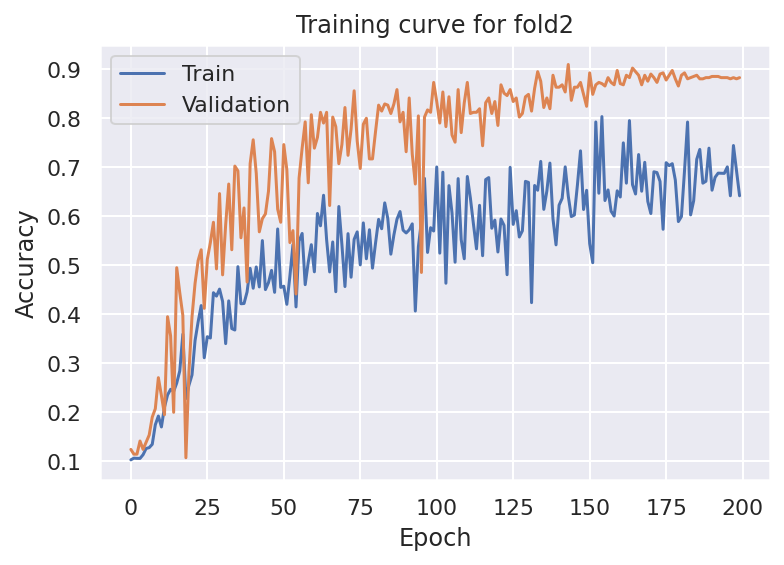

Epoch=0, Train loss=3.79927, Valid loss=6198.35160, Train Accuracy=0.10737, Validation Accuracy=0.10000
Epoch=10, Train loss=2.36819, Valid loss=3.07635, Train Accuracy=0.15145, Validation Accuracy=0.17805
Epoch=20, Train loss=2.20566, Valid loss=1.86808, Train Accuracy=0.27985, Validation Accuracy=0.38780
Epoch=30, Train loss=2.07122, Valid loss=1.60471, Train Accuracy=0.35916, Validation Accuracy=0.47561
Epoch=40, Train loss=1.99252, Valid loss=1.33857, Train Accuracy=0.42174, Validation Accuracy=0.63171
Epoch=50, Train loss=1.97116, Valid loss=1.07891, Train Accuracy=0.47956, Validation Accuracy=0.78049
Epoch=60, Train loss=1.78933, Valid loss=2.43026, Train Accuracy=0.55051, Validation Accuracy=0.57073
Epoch=70, Train loss=2.03551, Valid loss=1.18122, Train Accuracy=0.43108, Validation Accuracy=0.76098
Epoch=80, Train loss=1.60256, Valid loss=0.99911, Train Accuracy=0.64105, Validation Accuracy=0.76098
Epoch=90, Train loss=1.84872, Valid loss=1.23439, Train Accuracy=0.53626, Valida

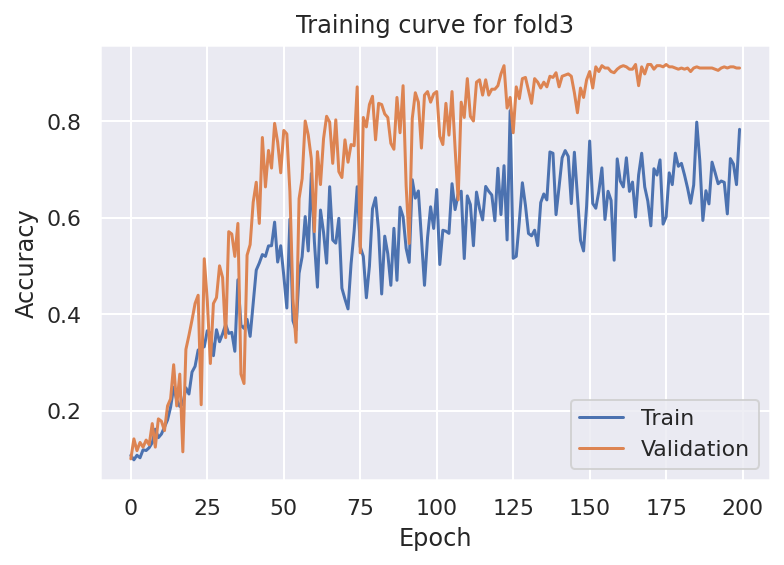

Epoch=0, Train loss=4.17198, Valid loss=2179.80081, Train Accuracy=0.10005, Validation Accuracy=0.11247
Epoch=10, Train loss=2.38074, Valid loss=2.04259, Train Accuracy=0.17294, Validation Accuracy=0.31540
Epoch=20, Train loss=2.14938, Valid loss=1.64699, Train Accuracy=0.32466, Validation Accuracy=0.46455
Epoch=30, Train loss=1.79150, Valid loss=1.26012, Train Accuracy=0.51475, Validation Accuracy=0.65281
Epoch=40, Train loss=1.86797, Valid loss=1.12398, Train Accuracy=0.48619, Validation Accuracy=0.67726
Epoch=50, Train loss=1.86350, Valid loss=1.07598, Train Accuracy=0.48864, Validation Accuracy=0.69438
Epoch=60, Train loss=1.70364, Valid loss=1.63440, Train Accuracy=0.57123, Validation Accuracy=0.63081
Epoch=70, Train loss=1.98915, Valid loss=1.31664, Train Accuracy=0.47019, Validation Accuracy=0.73350
Epoch=80, Train loss=1.42012, Valid loss=0.90942, Train Accuracy=0.71710, Validation Accuracy=0.78484
Epoch=90, Train loss=1.49927, Valid loss=0.89963, Train Accuracy=0.67892, Valida

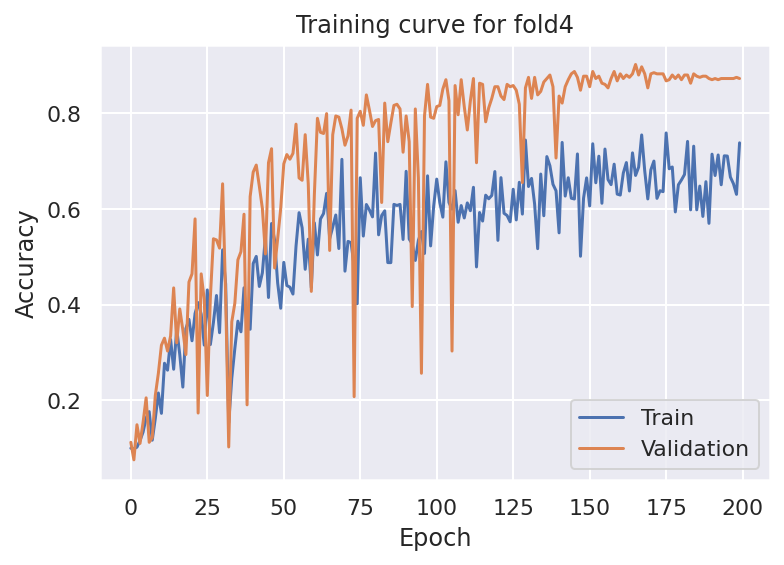

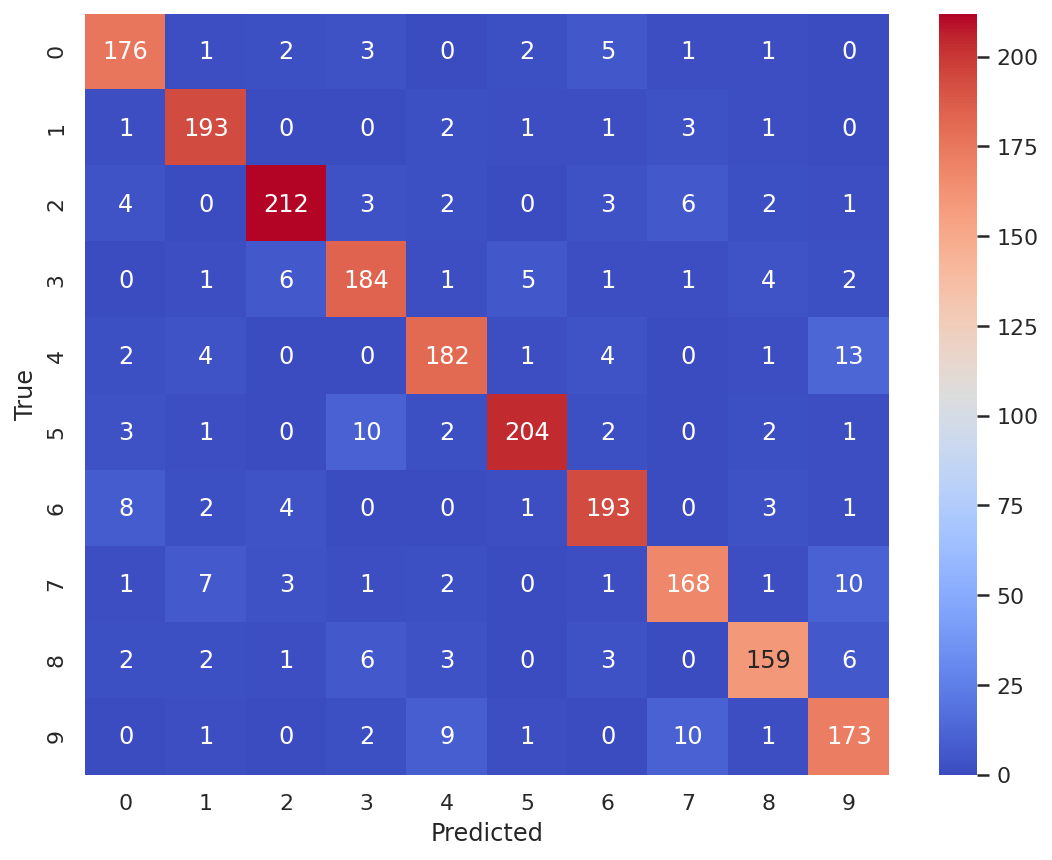

              precision    recall  f1-score   support

         0.0       0.89      0.92      0.91       191
         1.0       0.91      0.96      0.93       202
         2.0       0.93      0.91      0.92       233
         3.0       0.88      0.90      0.89       205
         4.0       0.90      0.88      0.89       207
         5.0       0.95      0.91      0.93       225
         6.0       0.91      0.91      0.91       212
         7.0       0.89      0.87      0.88       194
         8.0       0.91      0.87      0.89       182
         9.0       0.84      0.88      0.86       197

    accuracy                           0.90      2048
   macro avg       0.90      0.90      0.90      2048
weighted avg       0.90      0.90      0.90      2048

CV Accuracy Score=0.900390625
optimizer=adam, epochs=200, lr=0.003, wd=0.0005
CPU times: user 15min 50s, sys: 2min 3s, total: 17min 54s
Wall time: 19min 7s


In [12]:
%%time
epochs = 200
optim_name = "adam"
lr = 3e-3
wd = 5e-4
oof, targs = run(epochs, optim_name, lr, wd, augs, label_smooth=True, mixup=False, cutmix=True)
preds = np.argmax(oof, axis=1)
accuracy = metrics.accuracy_score(targs, preds)
print(f"CV Accuracy Score={accuracy}")
print(f"optimizer={optim_name}, epochs={epochs}, lr={lr}, wd={wd}")

Epoch=0, Train loss=9.13104, Valid loss=140.02687, Train Accuracy=0.09375, Validation Accuracy=0.09291
Epoch=10, Train loss=2.32108, Valid loss=2.20542, Train Accuracy=0.15918, Validation Accuracy=0.19071
Epoch=20, Train loss=2.23353, Valid loss=2.01079, Train Accuracy=0.22116, Validation Accuracy=0.30073
Epoch=30, Train loss=2.24698, Valid loss=1.97046, Train Accuracy=0.22837, Validation Accuracy=0.39364
Epoch=40, Train loss=1.95074, Valid loss=1.31350, Train Accuracy=0.41958, Validation Accuracy=0.59413
Epoch=50, Train loss=1.99863, Valid loss=1.48122, Train Accuracy=0.40487, Validation Accuracy=0.61614
Epoch=60, Train loss=1.90638, Valid loss=1.24696, Train Accuracy=0.47284, Validation Accuracy=0.75795
Epoch=70, Train loss=1.80148, Valid loss=1.05327, Train Accuracy=0.52663, Validation Accuracy=0.75795
Epoch=80, Train loss=1.63289, Valid loss=0.94625, Train Accuracy=0.61414, Validation Accuracy=0.78729
Epoch=90, Train loss=2.03078, Valid loss=1.29864, Train Accuracy=0.41762, Validat

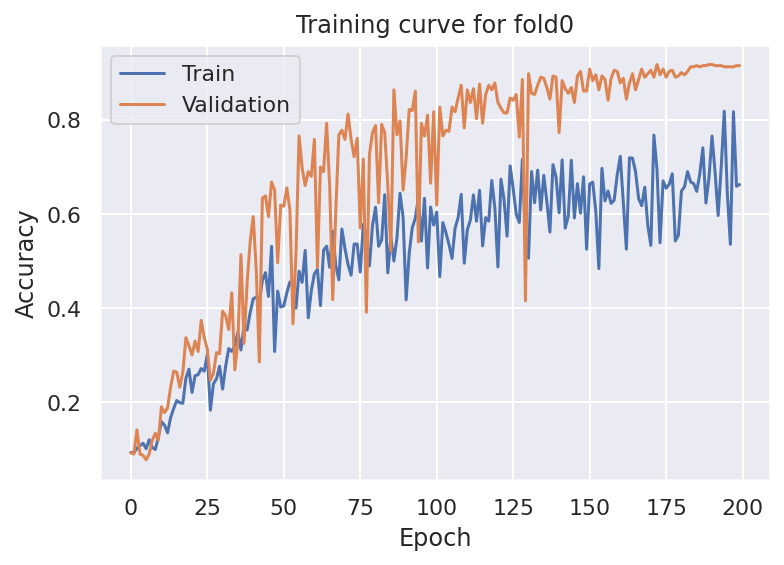

Epoch=0, Train loss=7.91891, Valid loss=63.81360, Train Accuracy=0.10272, Validation Accuracy=0.10000
Epoch=10, Train loss=2.35892, Valid loss=2.34091, Train Accuracy=0.11335, Validation Accuracy=0.09756
Epoch=20, Train loss=2.29312, Valid loss=2.11941, Train Accuracy=0.17528, Validation Accuracy=0.24634
Epoch=30, Train loss=2.19217, Valid loss=1.85512, Train Accuracy=0.25969, Validation Accuracy=0.48049
Epoch=40, Train loss=1.93313, Valid loss=1.39688, Train Accuracy=0.43617, Validation Accuracy=0.57317
Epoch=50, Train loss=1.80892, Valid loss=1.30887, Train Accuracy=0.51564, Validation Accuracy=0.65122
Epoch=60, Train loss=1.95918, Valid loss=1.21544, Train Accuracy=0.44642, Validation Accuracy=0.80244
Epoch=70, Train loss=1.87557, Valid loss=1.00529, Train Accuracy=0.51423, Validation Accuracy=0.77561
Epoch=80, Train loss=1.78129, Valid loss=1.16571, Train Accuracy=0.55688, Validation Accuracy=0.79268
Epoch=90, Train loss=1.72885, Valid loss=1.08805, Train Accuracy=0.58366, Validati

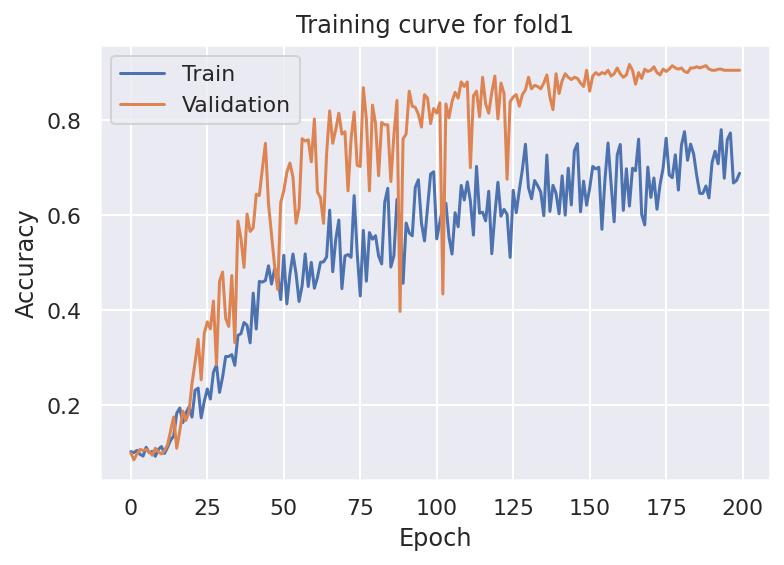

Epoch=0, Train loss=8.23481, Valid loss=852.50887, Train Accuracy=0.09261, Validation Accuracy=0.09268
Epoch=10, Train loss=2.24070, Valid loss=2.02161, Train Accuracy=0.22128, Validation Accuracy=0.27317
Epoch=20, Train loss=2.17593, Valid loss=1.93193, Train Accuracy=0.26462, Validation Accuracy=0.36585
Epoch=30, Train loss=2.01890, Valid loss=1.46880, Train Accuracy=0.40782, Validation Accuracy=0.61707
Epoch=40, Train loss=1.98519, Valid loss=1.45674, Train Accuracy=0.44178, Validation Accuracy=0.64146
Epoch=50, Train loss=1.76166, Valid loss=1.18929, Train Accuracy=0.53880, Validation Accuracy=0.67317
Epoch=60, Train loss=1.76525, Valid loss=1.02888, Train Accuracy=0.55067, Validation Accuracy=0.73902
Epoch=70, Train loss=1.78477, Valid loss=0.89613, Train Accuracy=0.55245, Validation Accuracy=0.78780
Epoch=80, Train loss=1.84422, Valid loss=1.06937, Train Accuracy=0.51486, Validation Accuracy=0.74878
Epoch=90, Train loss=1.77433, Valid loss=0.81642, Train Accuracy=0.55670, Validat

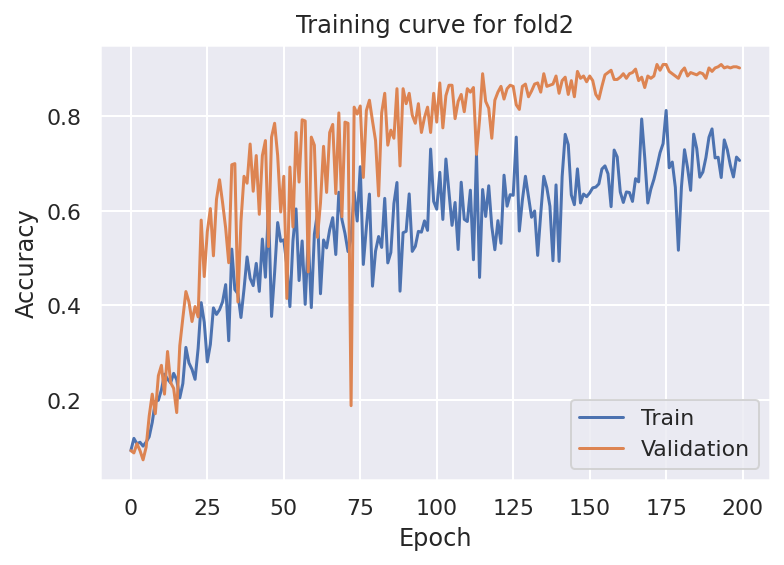

Epoch=0, Train loss=9.14102, Valid loss=176.18812, Train Accuracy=0.09874, Validation Accuracy=0.09512
Epoch=10, Train loss=2.39822, Valid loss=2.29747, Train Accuracy=0.09791, Validation Accuracy=0.10976
Epoch=20, Train loss=2.33971, Valid loss=2.32898, Train Accuracy=0.11797, Validation Accuracy=0.10244
Epoch=30, Train loss=2.33507, Valid loss=2.28823, Train Accuracy=0.12439, Validation Accuracy=0.16829
Epoch=40, Train loss=2.20566, Valid loss=1.90138, Train Accuracy=0.24792, Validation Accuracy=0.38293
Epoch=50, Train loss=1.89007, Valid loss=1.27910, Train Accuracy=0.45748, Validation Accuracy=0.65610
Epoch=60, Train loss=2.00796, Valid loss=1.85848, Train Accuracy=0.42929, Validation Accuracy=0.45610
Epoch=70, Train loss=1.69281, Valid loss=0.93887, Train Accuracy=0.58056, Validation Accuracy=0.75610
Epoch=80, Train loss=1.90814, Valid loss=1.25347, Train Accuracy=0.49083, Validation Accuracy=0.74146
Epoch=90, Train loss=1.67644, Valid loss=0.81772, Train Accuracy=0.59332, Validat

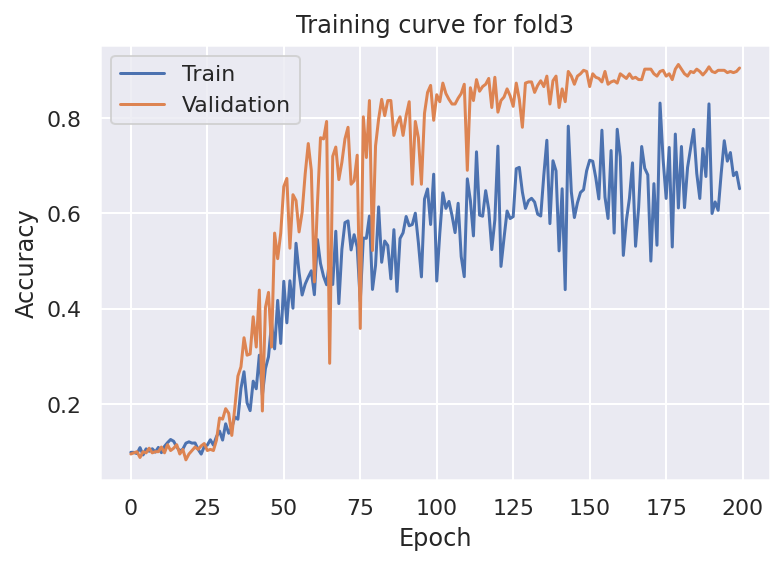

Epoch=0, Train loss=7.52799, Valid loss=332.98029, Train Accuracy=0.11160, Validation Accuracy=0.10269
Epoch=10, Train loss=2.33305, Valid loss=2.30759, Train Accuracy=0.11386, Validation Accuracy=0.13692
Epoch=20, Train loss=2.19946, Valid loss=2.03487, Train Accuracy=0.23798, Validation Accuracy=0.26650
Epoch=30, Train loss=2.05974, Valid loss=1.57818, Train Accuracy=0.32914, Validation Accuracy=0.45232
Epoch=40, Train loss=1.87003, Valid loss=1.54539, Train Accuracy=0.47334, Validation Accuracy=0.64059
Epoch=50, Train loss=2.04099, Valid loss=1.38367, Train Accuracy=0.39543, Validation Accuracy=0.64792
Epoch=60, Train loss=1.82759, Valid loss=1.21545, Train Accuracy=0.51343, Validation Accuracy=0.66504
Epoch=70, Train loss=1.79075, Valid loss=0.96573, Train Accuracy=0.55416, Validation Accuracy=0.81663
Epoch=80, Train loss=1.56085, Valid loss=0.89588, Train Accuracy=0.65095, Validation Accuracy=0.77017
Epoch=90, Train loss=1.61595, Valid loss=0.91733, Train Accuracy=0.62235, Validat

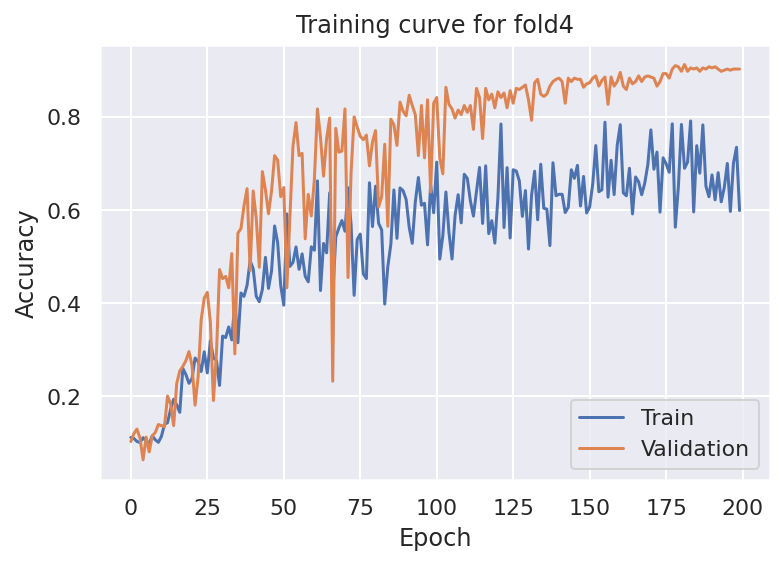

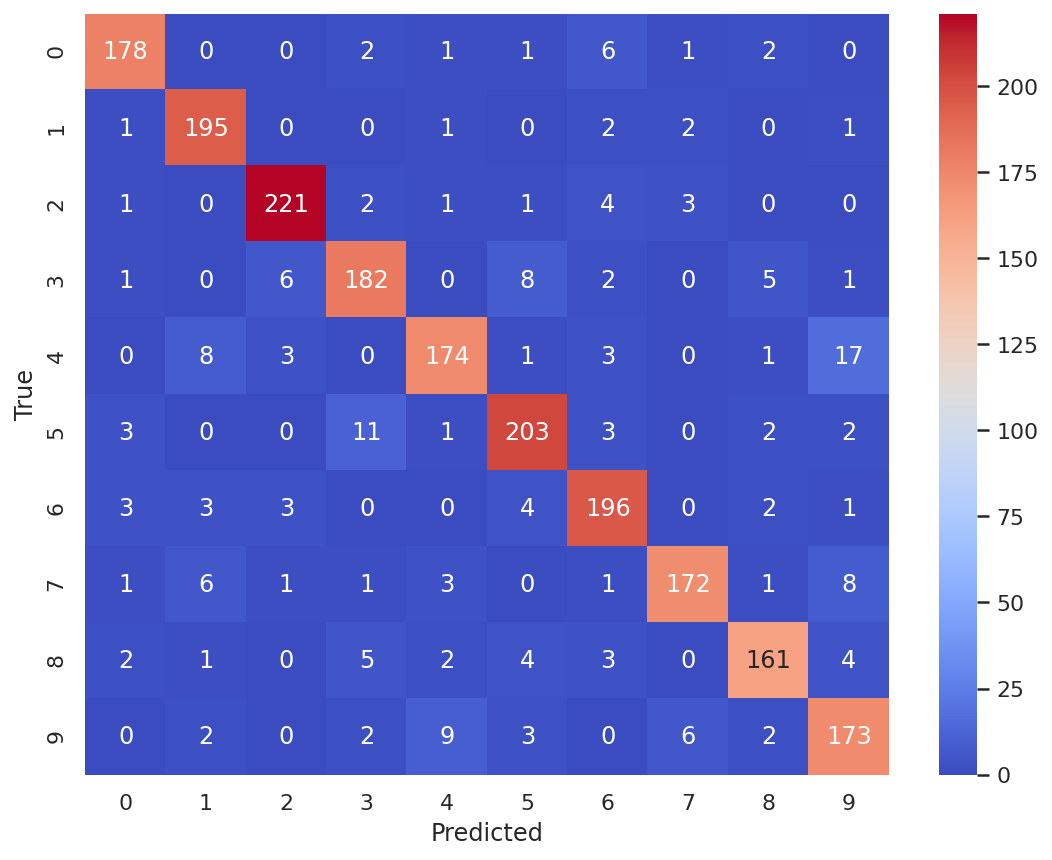

              precision    recall  f1-score   support

         0.0       0.94      0.93      0.93       191
         1.0       0.91      0.97      0.94       202
         2.0       0.94      0.95      0.95       233
         3.0       0.89      0.89      0.89       205
         4.0       0.91      0.84      0.87       207
         5.0       0.90      0.90      0.90       225
         6.0       0.89      0.92      0.91       212
         7.0       0.93      0.89      0.91       194
         8.0       0.91      0.88      0.90       182
         9.0       0.84      0.88      0.86       197

    accuracy                           0.91      2048
   macro avg       0.91      0.91      0.91      2048
weighted avg       0.91      0.91      0.91      2048

CV Accuracy Score=0.90576171875
optimizer=adam, epochs=200, lr=0.003, wd=0.0005
CPU times: user 9min 36s, sys: 2min, total: 11min 36s
Wall time: 12min 40s


In [32]:
%%time
epochs = 200
optim_name = "adam"
lr = 3e-3
wd = 5e-4
oof, targs = run(epochs, optim_name, lr, wd, augs, label_smooth=True, mixup=False, cutmix=True)
preds = np.argmax(oof, axis=1)
accuracy = metrics.accuracy_score(targs, preds)
print(f"CV Accuracy Score={accuracy}")
print(f"optimizer={optim_name}, epochs={epochs}, lr={lr}, wd={wd}")